In [26]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore")

# Directory where the CSV files are located
weather_directory = "Cleaned Weather Datasets"
agriculture_data = pd.read_csv('Cleaned Agriculture Datasets/crop.csv')

In [27]:

# List of states
states = [
    'ALABAMA', 'ARKANSAS', 'ARIZONA', 'CALIFORNIA', 'COLORADO', 'DELAWARE', 'FLORIDA', 'GEORGIA', 'IDAHO',
    'ILLINOIS', 'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MARYLAND', 'MICHIGAN', 'MINNESOTA',
    'MISSISSIPPI', 'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW JERSEY', 'NEW MEXICO', 'NEW YORK',
    'NORTH CAROLINA', 'NORTH DAKOTA','OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA', 'SOUTH CAROLINA',
    'SOUTH DAKOTA', 'TENNESSEE', 'TEXAS', 'UTAH', 'VIRGINIA', 'WASHINGTON', 'WEST VIRGINIA', 'WISCONSIN',
    'WYOMING'
]

# Function to read CSV files
def read_csv_files(weather_directory, states):
    dataframes = {}
    for state in states:
        filename = os.path.join(weather_directory, state + '.csv')
        if os.path.exists(filename):
            dataframes[state] = pd.read_csv(filename)
        else:
            print(f"File not found: {filename}")
    return dataframes

# Read CSV files
state_data = read_csv_files(weather_directory, states)

# Combine data from all states
merged_dfs = []

for state, data in state_data.items():
    # Convert the 'DATE' column to datetime format
    data['DATE'] = pd.to_datetime(data['DATE'])

    # Extract the year and month from the 'DATE' column and create new 'YEAR' and 'MONTH' columns
    data['YEAR'] = data['DATE'].dt.year
    data['MONTH'] = data['DATE'].dt.month

    # Define a dictionary to map month numbers to month names
    month_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }

    # Replace numerical month values with month names
    data['MONTH'] = data['MONTH'].map(month_names)

    # Group the data by 'YEAR' and 'MONTH' and calculate the mean for each group
    monthly_average = data.groupby(['YEAR', 'MONTH']).agg({
        'PRCP': 'mean',
        'SNOW': 'mean',
        'SNWD': 'mean',
        'TAVG': 'mean',
        'TMAX': 'mean',
        'TMIN': 'mean',
        'STATE': 'first',  # retain the STATE column
        'REGION': 'first',  # retain the REGION column
    }).reset_index()

    # Pivot the data to have separate columns for each weather type and month
    pivot_data = monthly_average.pivot_table(index=['YEAR', 'STATE', 'REGION'], columns=['MONTH'], values=['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], aggfunc='mean').reset_index()

    # Flatten the multi-level columns
    pivot_data.columns = [' '.join(col).strip() for col in pivot_data.columns.values]

    # Append to list of merged DataFrames
    merged_dfs.append(pivot_data)

# Concatenate all DataFrames into one
final_merged_df = pd.concat(merged_dfs, ignore_index=True)


In [28]:

final_merged_df_1 = final_merged_df[final_merged_df['STATE'] == 'DELAWARE']

# Exclude non-numeric columns
numeric_cols = final_merged_df_1.select_dtypes(include='number').columns

final_merged_df_1[numeric_cols] = final_merged_df_1[numeric_cols].fillna(final_merged_df_1[numeric_cols].mean())

# Drop rows where STATE is DELAWARE
final_merged_df_3 = final_merged_df[final_merged_df['STATE'] != 'DELAWARE']

# Assuming final_merged_df_2 and final_merged_df_3 are your DataFrames
# Concatenate the two DataFrames
weather_clean = pd.concat([final_merged_df_1, final_merged_df_3], ignore_index=True)


agriculture_clean = agriculture_data.pivot_table(index=['YEAR', 'STATE', 'COMMODITY'],
                                                columns='DATA ITEM',
                                                values='VALUE',
                                                aggfunc='sum')

# Reset index to make the resulting DataFrame cleaner
agriculture_clean.reset_index(inplace=True)

# Rename the columns to remove leading spaces
agriculture_clean.columns = agriculture_clean.columns.str.strip()

agriculture_clean = agriculture_clean[agriculture_clean['STATE'] != 'OTHER STATES']

# Merge final_merged_df with soybeans_data
df_1 = pd.merge(weather_clean,agriculture_clean, on=['YEAR', 'STATE'])

# Display the resulting DataFrame
print(df_1)


      YEAR     STATE REGION  PRCP Apr  PRCP Aug  PRCP Dec  PRCP Feb  PRCP Jan  \
0     2008  DELAWARE  SOUTH  0.096667  0.019355  0.158065  0.134483  0.074194   
1     2008  DELAWARE  SOUTH  0.096667  0.019355  0.158065  0.134483  0.074194   
2     2009  DELAWARE  SOUTH  0.180000  0.293548  0.280645  0.107180  0.090323   
3     2009  DELAWARE  SOUTH  0.180000  0.293548  0.280645  0.107180  0.090323   
4     2010  DELAWARE  SOUTH  0.083333  0.125806  0.074194  0.107143  0.058065   
...    ...       ...    ...       ...       ...       ...       ...       ...   
1100  2018   WYOMING   WEST  0.036975  0.020000  0.020000  0.020952  0.025000   
1101  2019   WYOMING   WEST  0.059200  0.008387  0.030719  0.041727  0.019481   
1102  2020   WYOMING   WEST  0.030667  0.006452  0.018065  0.032639  0.025325   
1103  2021   WYOMING   WEST  0.020134  0.039355  0.030065  0.043165  0.013014   
1104  2022   WYOMING   WEST  0.037917  0.036032  0.027869  0.004911  0.012903   

      PRCP Jul  PRCP Jun  .

In [29]:
# Define conversion factors
conversion_factors = {'SOYBEANS': 60, 'WHEAT': 60}

# Update yield values for soybeans and wheat based on the crop name in the 'commodity' column
for index, row in df_1.iterrows():
    if row['COMMODITY'] in conversion_factors:
        df_1.at[index, 'YIELD'] *= conversion_factors[row['COMMODITY']]


In [30]:
from sklearn.preprocessing import LabelEncoder

# label encoding 'STATE'
label_encoder = LabelEncoder()
df_1['STATE'] = label_encoder.fit_transform(df_1['STATE'])


In [31]:
from sklearn.preprocessing import LabelEncoder

# label encoding 'REGION'
label_encoder = LabelEncoder()
df_1['REGION'] = label_encoder.fit_transform(df_1['REGION'])


In [32]:
import category_encoders as ce

# Example for frequency encoding 'COMMODITY'
encoder = ce.CountEncoder(cols=['COMMODITY'])
df_1 = encoder.fit_transform(df_1)


In [33]:
df_1.head(10)

,YEAR,STATE,REGION,PRCP Apr,PRCP Aug,PRCP Dec,PRCP Feb,PRCP Jan,PRCP Jul,PRCP Jun,...,TMIN Jun,TMIN Mar,TMIN May,TMIN Nov,TMIN Oct,TMIN Sep,COMMODITY,ACRES HARVESTED,ACRES PLANTED,YIELD
0,2008,5,2,0.096667,0.019355,0.158065,0.134483,0.074194,0.154839,0.083333,...,66.033333,36.741935,51.967742,39.400000,47.838710,62.466667,431,193000.0,195000.0,1650.0
1,2008,5,2,0.096667,0.019355,0.158065,0.134483,0.074194,0.154839,0.083333,...,66.033333,36.741935,51.967742,39.400000,47.838710,62.466667,584,79000.0,85000.0,4620.0
2,2009,5,2,0.180000,0.293548,0.280645,0.107180,0.090323,0.067742,0.200000,...,62.866667,36.056068,54.774194,43.400000,48.580645,59.766667,431,183000.0,185000.0,2520.0
3,2009,5,2,0.180000,0.293548,0.280645,0.107180,0.090323,0.067742,0.200000,...,62.866667,36.056068,54.774194,43.400000,48.580645,59.766667,584,63000.0,65000.0,3660.0
4,2010,5,2,0.083333,0.125806,0.074194,0.107143,0.058065,0.219355,0.046667,...,67.833333,39.161290,57.290323,37.533333,50.483871,61.800000,431,173000.0,175000.0,1920.0
5,2010,5,2,0.083333,0.125806,0.074194,0.107143,0.058065,0.219355,0.046667,...,67.833333,39.161290,57.290323,37.533333,50.483871,61.800000,584,47000.0,50000.0,3480.0
6,2011,5,2,0.113333,0.290323,0.138710,0.089286,0.103226,0.133333,0.060000,...,65.433333,35.064516,57.645161,41.433333,48.419355,64.100000,431,168000.0,170000.0,2370.0
7,2011,5,2,0.113333,0.290323,0.138710,0.089286,0.103226,0.133333,0.060000,...,65.433333,35.064516,57.645161,41.433333,48.419355,64.100000,584,75000.0,80000.0,4140.0
8,2012,5,2,0.010000,0.061290,0.132258,0.034483,0.048387,0.103226,0.033333,...,63.166667,42.387097,58.354839,34.600000,51.354839,59.200000,431,168000.0,170000.0,2550.0
9,2012,5,2,0.010000,0.061290,0.132258,0.034483,0.048387,0.103226,0.033333,...,63.166667,42.387097,58.354839,34.600000,51.354839,59.200000,584,76000.0,80000.0,4440.0


In [34]:
from catboost import CatBoostRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

target_variable = 'YIELD'
features = df_1.drop(columns=[target_variable])
label = df_1[target_variable]

train_data, test_data, train_labels, test_labels = train_test_split(features, label, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "Linear Regression": LinearRegression(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor(),
}

params = {
    "Decision Tree": {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
    },
    "Random Forest": {
        'n_estimators': [8, 16, 32, 64, 128, 256]
    },
    "Gradient Boosting": {
        'learning_rate': [.1, .01, .05, .001],
        'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
        'n_estimators': [8, 16, 32, 64, 128, 256]
    },
    "Linear Regression": {},
    "XGBRegressor": {
        'learning_rate': [.1, .01, .05, .001],
        'n_estimators': [8, 16, 32, 64, 128, 256]
    },
    "CatBoosting Regressor": {
        'depth': [6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [30, 50, 100]
    },
    "AdaBoost Regressor": {
        'learning_rate': [.1, .01, 0.5, .001],
        'n_estimators': [8, 16, 32, 64, 128, 256]
    }
}


def evaluate_models(train_data, train_labels, test_data, test_labels, models, param):
    try:
        report = {}

        for i in range(len(list(models))):
            model = list(models.values())[i]
            para = param[list(models.keys())[i]]

            gs = GridSearchCV(model, para, cv=3)
            gs.fit(train_data, train_labels)

            model.set_params(**gs.best_params_)
            model.fit(train_data, train_labels)

            y_train_pred = model.predict(train_data)
            y_test_pred = model.predict(test_data)

            train_model_score = r2_score(train_labels, y_train_pred)
            test_model_score = r2_score(test_labels, y_test_pred)

            report[list(models.keys())[i]] = test_model_score

        return report

    except Exception as e:
        print(f"Error occurred: {e}")


model_report = evaluate_models(train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, models=models, param=params)

best_model_score = max(sorted(model_report.values()))

best_model_name = list(model_report.keys())[list(model_report.values()).index(best_model_score)]
best_model = models[best_model_name]

predicted = best_model.predict(test_data)

print("Best Model Score:", best_model_score)
print("Best Model Name:", best_model_name)

Best Model Score: 0.9374401051171667
Best Model Name: XGBRegressor


In [35]:
    score = r2_score(test_labels, predicted)*100
    print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 93.74


#### Plotting test_labels and predicted

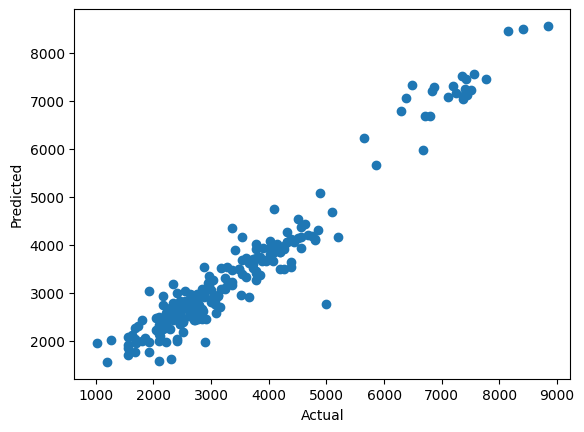

In [36]:
plt.scatter(test_labels, predicted);
plt.xlabel('Actual');
plt.ylabel('Predicted');

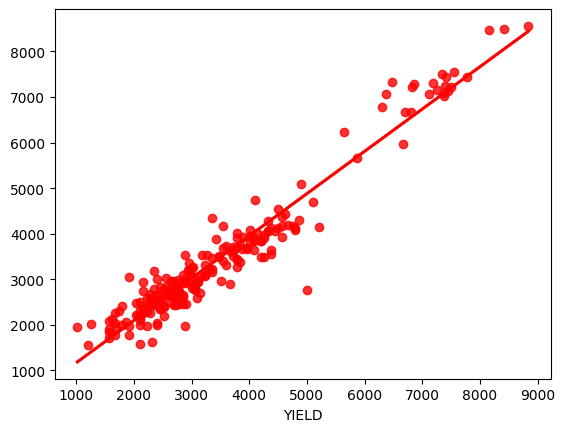

In [37]:
import seaborn as sns
sns.regplot(x=test_labels,y=predicted,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [38]:
pred_df=pd.DataFrame({'Actual Value':test_labels,'Predicted Value':predicted,'Difference':test_labels-predicted})
pred_df

,Actual Value,Predicted Value,Difference
309,3780.0,3453.402344,326.597656
1042,4020.0,4072.878174,-52.878174
381,6300.0,6780.439453,-480.439453
497,2850.0,3087.650391,-237.650391
551,7370.0,7027.877441,342.122559
...,...,...,...
1058,2346.0,3173.490967,-827.490967
321,2520.0,2661.816895,-141.816895
983,2220.0,1984.853149,235.146851
925,2040.0,2220.464355,-180.464355
